In [1]:
!pip install torch==2.8.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --only-binary :all:
!pip install transformers accelerate pandas scikit-learn unidecode nltk seaborn tqdm emoji matplotlib --only-binary :all:

Looking in indexes: https://download.pytorch.org/whl/cu121
ERROR: Could not find a version that satisfies the requirement torch==2.8.0 (from versions: 2.1.0+cu121, 2.1.1+cu121, 2.1.2+cu121, 2.2.0+cu121, 2.2.1+cu121, 2.2.2+cu121, 2.3.0+cu121, 2.3.1+cu121, 2.4.0+cu121, 2.4.1+cu121, 2.5.0+cu121, 2.5.1+cu121)
ERROR: No matching distribution found for torch==2.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:0

In [2]:
# Cell 2: Imports

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from unidecode import unidecode
from nltk.tokenize import sent_tokenize
import warnings
import os
import torch
from transformers import AutoTokenizer

warnings.filterwarnings("ignore")

In [3]:
# Cell 3: Configuration

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
    print("Kaggle secrets (HF_TOKEN) loaded.")
except ImportError:
    print("Kaggle secrets not found. Using None for HF_TOKEN.")
    HF_TOKEN = None
except Exception as e:
    print(f"Error loading secrets: {e}. Using None for HF_TOKEN.")
    HF_TOKEN = None


class CFG:
    # --- Original Parameters (Kept for consistency/reference) ---
    MODEL_NAME = 'vinai/bertweet-base'
    TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)

    MAX_LEN = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    FP16 = True  # Use Mixed Precision for evaluation if available
    EPOCHS = 50  # Not needed for evaluation/ensembling
    LEARNING_RATE = 3e-5  # Not needed for evaluation/ensembling
    ACCUMULATION_STEPS = 2
    WARMUP_RATIO = 0.06
    LABEL_SMOOTHING = 0.1

    WEIGHT_DECAY = 0.01
    SCHEDULER = "r-drop"
    DROPOUT = 0.3
    CLIP_GRAD_NORM = 1.0
    R_DROP_ALPHA = 5

    NUM_WORKERS = 0
    PATIENCE = 4
    SEED = 3141

    OUTPUT_DIR = "/kaggle/working/"

    # Data directories
    DATA_DIR = "/kaggle/input/emotion/Emotion/"
    MODEL_INPUT_DIR = "/kaggle/input/bert-fine-tune-seed-colab/pytorch/default/2"

    # Ensemble model filenames
    MODEL_FILENAMES = [
        "model_seed_101.pth",
        "model_seed_2468.pth",
        "model_seed_3141.pth",
        "model_seed_5555.pth",
        "model_seed_90210.pth"
    ]

    BATCH_SIZE = 8

    LOGITS_DIR = "/kaggle/input/logits-ensemble-logits-npy/pytorch/default/1/"


Kaggle secrets (HF_TOKEN) loaded.


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [4]:
# Cell 4: Data Loading & Preprocessing

try:
    train_df = pd.read_csv(os.path.join(CFG.DATA_DIR, "train.csv"))
    val_df = pd.read_csv(os.path.join(CFG.DATA_DIR, "val.csv"))
    test_df = pd.read_csv(os.path.join(CFG.DATA_DIR, "test.csv"))
    print("Data loaded successfully.")
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
except FileNotFoundError:
    print(f"Error: CSV files not found in '{CFG.DATA_DIR}'. Please check the path in CFG.")
    train_df = pd.DataFrame(columns=['text', 'label'])
    val_df = pd.DataFrame(columns=['text', 'label'])
    test_df = pd.DataFrame(columns=['text', 'label'])
except Exception as e:
    print(f"An error occurred loading data: {e}")
    raise


def pre_process_document(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<[^>]+>', ' ', text)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\\'s", " ", text)
    text = re.sub(r"\\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\\'re", " are ", text)
    text = re.sub(r"\\'d", " would ", text)
    text = re.sub(r"\\'ll", " will ", text)
    text = unidecode(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


print("Applying preprocessing...")
train_df['text_processed'] = train_df['text'].apply(pre_process_document)
val_df['text_processed'] = val_df['text'].apply(pre_process_document)
test_df['text_processed'] = test_df['text'].apply(pre_process_document)

le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
val_df['label_encoded'] = le.transform(val_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

NUM_CLASSES = len(le.classes_)
CLASS_NAMES = le.classes_
print(f"Classes: {CLASS_NAMES}")

Data loaded successfully.
Train: 3613, Val: 347, Test: 3142
Applying preprocessing...
Classes: ['anger' 'fear' 'joy' 'sadness']


In [5]:
print(f"Loading logits from {CFG.LOGITS_DIR}...")
#ensemble_train_logits = np.load(os.path.join(CFG.LOGITS_DIR, 'ensemble_train_logits.npy'))
#ensemble_val_logits   = np.load(os.path.join(CFG.LOGITS_DIR, 'ensemble_val_logits.npy'))
#ensemble_test_logits  = np.load(os.path.join(CFG.LOGITS_DIR, 'ensemble_test_logits.npy'))

# Cell 5: Load Pre-Computed Logits


try:
    ensemble_train_logits = np.load(os.path.join(CFG.LOGITS_DIR, 'ensemble_train_logits.npy'))
    ensemble_val_logits   = np.load(os.path.join(CFG.LOGITS_DIR, 'ensemble_val_logits.npy'))
    ensemble_test_logits  = np.load(os.path.join(CFG.LOGITS_DIR, 'ensemble_test_logits.npy'))
    
    print("Successfully loaded logit files.")
    print(f"Train logits shape: {ensemble_train_logits.shape}")
    print(f"Val logits shape: {ensemble_val_logits.shape}")
    print(f"Test logits shape: {ensemble_test_logits.shape}")
    
except FileNotFoundError:
    print(f"Error: Logit files not found in '{CFG.LOGITS_DIR}'.")
    print("Please ensure 'ensemble_train_logits.npy', 'ensemble_val_logits.npy', and 'ensemble_test_logits.npy' exist in that directory.")
    ensemble_train_logits = np.zeros((len(train_df), NUM_CLASSES))
    ensemble_val_logits = np.zeros((len(val_df), NUM_CLASSES))
    ensemble_test_logits = np.zeros((len(test_df), NUM_CLASSES))
except Exception as e:
    print(f"An error occurred: {e}")


Loading logits from /kaggle/input/logits-ensemble-logits-npy/pytorch/default/1/...
Successfully loaded logit files.
Train logits shape: (3613, 4)
Val logits shape: (347, 4)
Test logits shape: (3142, 4)


In [6]:
# Cell 6: Get Ensemble Predictions
train_preds = np.argmax(ensemble_train_logits, axis=1)
val_preds   = np.argmax(ensemble_val_logits, axis=1)
test_preds  = np.argmax(ensemble_test_logits, axis=1)

train_labels_true = train_df['label_encoded'].values
val_labels_true   = val_df['label_encoded'].values
test_labels_true  = test_df['label_encoded'].values

print("Predictions calculated.")

Predictions calculated.


In [7]:
# Cell 7: Classification Report (6 Decimals)
print("--- 🚀 Ensemble Classification Report (Test Set) ---")

report = classification_report(
    test_labels_true, 
    test_preds, 
    target_names=CLASS_NAMES, 
    digits=6
)
print(report)

print("\n--- 🚀 Ensemble Classification Report (Validation Set) ---")
report_val = classification_report(
    val_labels_true, 
    val_preds, 
    target_names=CLASS_NAMES, 
    digits=6
)
print(report_val)

--- 🚀 Ensemble Classification Report (Test Set) ---
              precision    recall  f1-score   support

       anger   0.901114  0.851316  0.875507       760
        fear   0.866667  0.901508  0.883744       995
         joy   0.942029  0.910364  0.925926       714
     sadness   0.846924  0.879643  0.862974       673

    accuracy                       0.886696      3142
   macro avg   0.889184  0.885708  0.887038      3142
weighted avg   0.887896  0.886696  0.886888      3142


--- 🚀 Ensemble Classification Report (Validation Set) ---
              precision    recall  f1-score   support

       anger   0.903614  0.892857  0.898204        84
        fear   0.893805  0.918182  0.905830       110
         joy   0.924051  0.924051  0.924051        79
     sadness   0.902778  0.878378  0.890411        74

    accuracy                       0.904899       347
   macro avg   0.906062  0.903367  0.904624       347
weighted avg   0.904979  0.904899  0.904844       347



In [8]:
# Cell 8: Generate Predictions CSV
print("Generating predictions CSV...")

original_texts = test_df['text'].values
true_label_names = test_df['label'].values
predicted_label_names = le.inverse_transform(test_preds)

predictions_df = pd.DataFrame({
    'text': original_texts,
    'predicted_label_name': predicted_label_names,
    'true_label_name': true_label_names
})

csv_path = '/kaggle/working/test_predictions.csv'
predictions_df.to_csv(csv_path, index=False)

print(f"✅ Predictions CSV file saved to: {csv_path}")
print("\nCSV file head:")
print(predictions_df.head())

Generating predictions CSV...
✅ Predictions CSV file saved to: /kaggle/working/test_predictions.csv

CSV file head:
                                                text predicted_label_name  \
0  You must be knowing #blithe means (adj.)  Happ...                  joy   
1  Old saying 'A #smile shared is one gained for ...                  joy   
2  Bridget Jones' Baby was bloody hilarious 😅 #Br...                  joy   
3  @Elaminova sparkling water makes your life spa...                  joy   
4  I'm tired of everybody telling me to chill out...                  joy   

  true_label_name  
0             joy  
1             joy  
2             joy  
3             joy  
4             joy  



Generating confusion matrices...


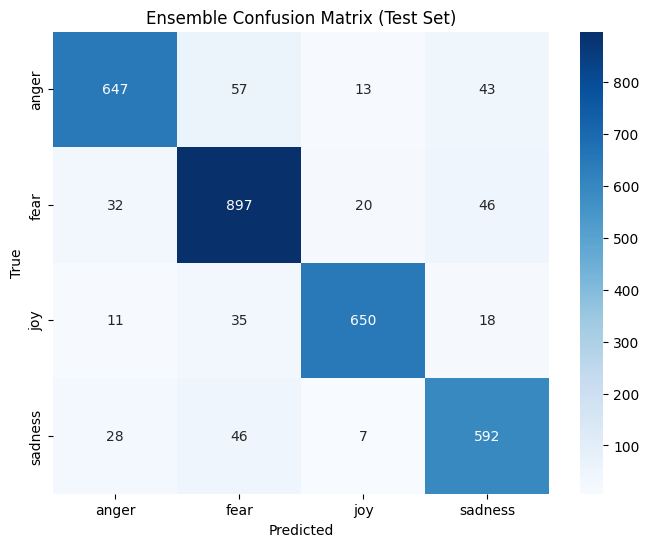

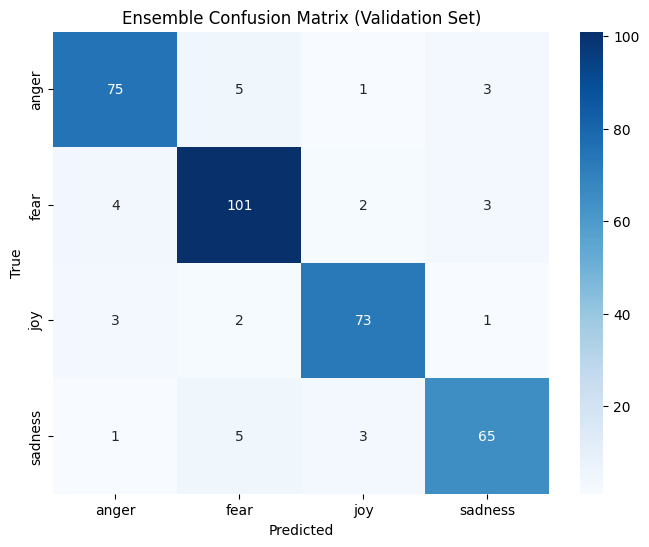

In [9]:
#Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print("\nGenerating confusion matrices...")
plot_cm(test_labels_true, test_preds, "Ensemble Confusion Matrix (Test Set)", CLASS_NAMES)
plot_cm(val_labels_true, val_preds, "Ensemble Confusion Matrix (Validation Set)", CLASS_NAMES)


In [10]:
def evaluate_metrics(y_true, y_pred, name):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{name} Set Metrics:")
    print(f"  Precision: {precision:.6f}")
    print(f"  Recall:    {recall:.6f}")
    print(f"  F1 Score:  {f1:.6f}")
    print("-" * 40)

# Evaluate for each dataset
evaluate_metrics(train_labels_true, train_preds, "Train")
evaluate_metrics(val_labels_true, val_preds, "Validation")
evaluate_metrics(test_labels_true, test_preds, "Test")


Train Set Metrics:
  Precision: 0.963646
  Recall:    0.963124
  F1 Score:  0.963330
----------------------------------------
Validation Set Metrics:
  Precision: 0.906062
  Recall:    0.903367
  F1 Score:  0.904624
----------------------------------------
Test Set Metrics:
  Precision: 0.889184
  Recall:    0.885708
  F1 Score:  0.887038
----------------------------------------
